In [2]:
## Dependencies
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Here is the OSF API endpoint for the data files for Syme and England, 2025 
api_url = "https://api.osf.io/v2/nodes/jasv5/files/osfstorage/"

# Get the file listing
response = requests.get(api_url)
files_data = response.json()

# Download each file
for file_info in files_data["data"]:
    filename = file_info["attributes"]["name"]
    download_url = file_info["links"]["download"]
    
    print(f"Downloading {filename}...")
    file_response = requests.get(download_url)
    
    filepath = os.path.join('./', filename)
    with open(filepath, "wb") as f:
        f.write(file_response.content)
    
    print(f"  Saved to {filepath}")

  Saved to ./Dataset2-marineseds.xlsx
  Saved to ./Dataset1-PTcompilation.xlsx
  Saved to ./Dataset3-mafics.xlsx


In [6]:
# Now, we are going to open up Dataset2-marineseds.xlsx and put it into a dataframe
marine_seds = pd.read_excel("Dataset2-marineseds.xlsx", header=2)

In [7]:
# Then, we are going to filter the data

# (a) All Fe was converted to Fe2+ and reported as FeOT (already done in the dataset)

# (b) Subtract CaO associated with apatite: CaO* = CaO - 10/3(P2O5) in molar proportions
# Molar masses
M_CaO = 56.08   # g/mol
M_P2O5 = 141.94 # g/mol

# Convert wt% to moles, apply correction, convert back to wt%
CaO_molar = marine_seds['CAO'] / M_CaO
P2O5_molar = marine_seds['P2O5'] / M_P2O5
CaO_star_molar = CaO_molar - (10/3) * P2O5_molar
marine_seds['CAO'] = CaO_star_molar * M_CaO

# (c) Discard samples with P2O5 exceeding 20 weight % (phosphorites)
marine_seds = marine_seds[marine_seds['P2O5'] <= 20]

print(f"Samples remaining after filtering: {len(marine_seds)}")

Samples remaining after filtering: 1982


In [8]:
# Next, we will extract only the column headers that correspond to geochemical measurements

# First, we will get all column names as a list
cols = marine_seds.columns.tolist()  
# Then, we will find the index position of 'ROCK NAME'
rock_idx = cols.index('ROCK NAME')  
# Finally, we will get the name of all the columns after ROCK NAME, excluding LATITUDE and LONGITUDE
geochem_cols = cols[rock_idx+1:-2]

# A little helper: map from column names to LaTeX formatted labels
latex_labels = {
    'SIO2': r'SiO$_2$', 'TIO2': r'TiO$_2$', 'AL2O3': r'Al$_2$O$_3$',
    'FEOT': r'FeO$_T$', 'MNO': r'MnO', 'MGO': r'MgO', 'CAO': r'CaO',
    'NA2O': r'Na$_2$O', 'K2O': r'K$_2$O', 'P2O5': r'P$_2$O$_5$', 'LOI': r'LOI'
}

print(geochem_cols)

['SIO2', 'TIO2', 'AL2O3', 'FEOT', 'MNO', 'MGO', 'CAO', 'NA2O', 'K2O', 'P2O5', 'LOI']


TypeError: 'value' must be an instance of str or bytes, not a int

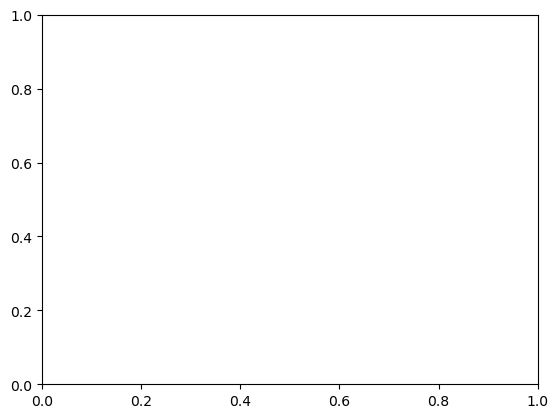

In [10]:
## Select one geochemistry measurement and characterize it (e.g., provide a visualization or list of statistics)
import matplotlib.pyplot as plt

plt.figure()
plt.hist(marine_seds, bins=30)
plt.xlabel(latex_labels.get(element, element))
plt.ylabel("Frequency")
plt.title(f"Distribution of {latex_labels.get(element, element)} in Marine Sediments")
plt.show()


Next, let us plot two variables against one another to understand how the are related.

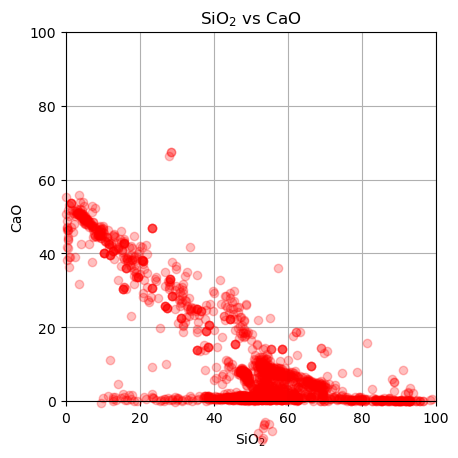

In [11]:
fig, ax = plt.subplots()
ax.scatter(marine_seds['SIO2'], marine_seds['CAO'], color='red', alpha=0.25, clip_on=False)
ax.set_xlabel(r'SiO$_2$')
ax.set_ylabel(r'CaO')
ax.set_title(r'SiO$_2$ vs CaO')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_aspect('equal')
ax.grid(True)
ax.set_axisbelow(True)

How do *all* of the geochemical measurements relate to one another?

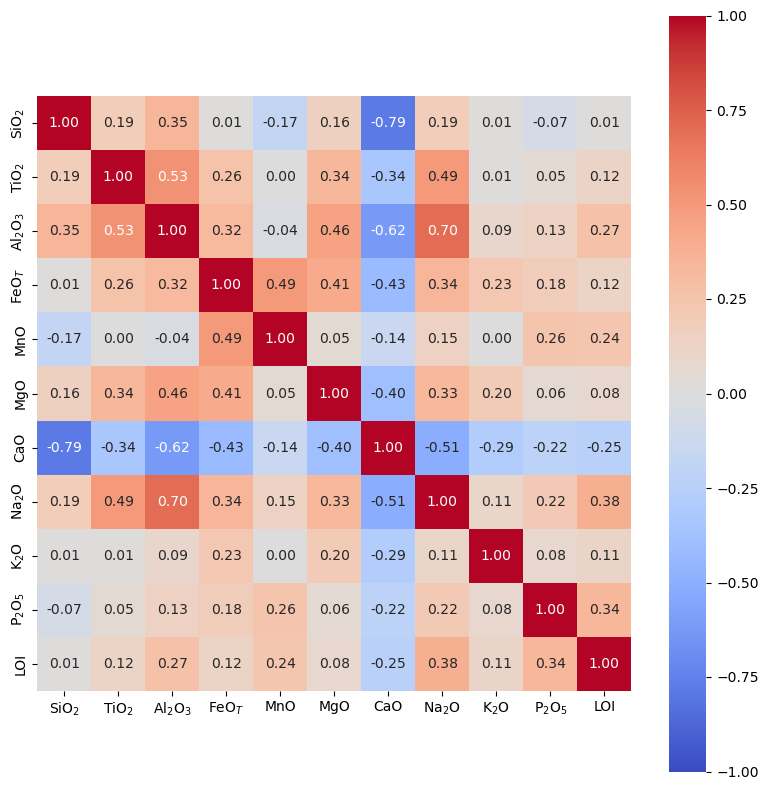

In [12]:
## Correlation coefficient matrix
df_geochem = marine_seds[geochem_cols]
corr_matrix = df_geochem.corr()

# Create LaTeX formatted labels for axes
latex_cols = [latex_labels[col] for col in geochem_cols]

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            vmin=-1, vmax=1, center=0, ax=ax, square=True,
            xticklabels=latex_cols, yticklabels=latex_cols)
plt.tight_layout()
plt.show()

## Implementing PCA

In [13]:
# First, we extract geochemical data and drop rows with NaN values
geochem = marine_seds[geochem_cols].dropna()

# Let's center the data by subtracting the mean
# Note that we do not *normalize* the data
geochem_centered = geochem - geochem.mean()

In [14]:
# Apply SVD to perform PCA (with centering to match sklearn)
geochem_centered = geochem - geochem.mean()
U, S, Vt = np.linalg.svd(geochem_centered, full_matrices=False)

# Project data onto principal components (scores)
pca_result = U * S

# Calculate explained variance ratio
explained_variance = (S ** 2) / (len(geochem_centered) - 1)
explained_variance_ratio = explained_variance / explained_variance.sum()

# What proportion is variance is explained by each PC?
print("Explained variance:")
for i, var in enumerate(explained_variance_ratio):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")

Explained variance:
  PC1: 0.7968 (79.68%)
  PC2: 0.1209 (12.09%)
  PC3: 0.0284 (2.84%)
  PC4: 0.0227 (2.27%)
  PC5: 0.0150 (1.50%)
  PC6: 0.0079 (0.79%)
  PC7: 0.0030 (0.30%)
  PC8: 0.0025 (0.25%)
  PC9: 0.0013 (0.13%)
  PC10: 0.0012 (0.12%)
  PC11: 0.0002 (0.02%)


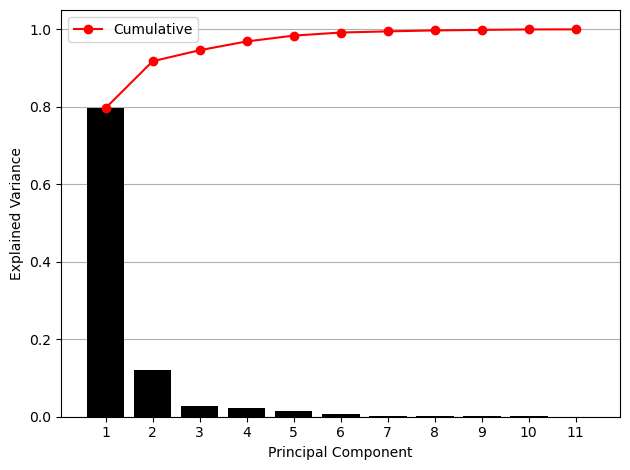

In [15]:
# We can also create a *scree* plot of pcs

fig, ax = plt.subplots()
ax.bar(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, 
       color='black')
ax.plot(range(1, len(explained_variance_ratio)+1), np.cumsum(explained_variance_ratio), 
        'ro-', label='Cumulative')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
ax.set_xticks(range(1, len(explained_variance_ratio)+1))
ax.legend()
ax.grid(True, axis='y')
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

### Let's visualize the results of our PCA

Before we do, we will just flip the axes.

In [16]:
pca_result[:, 0] *= -1
pca_result[:, 1] *= -1

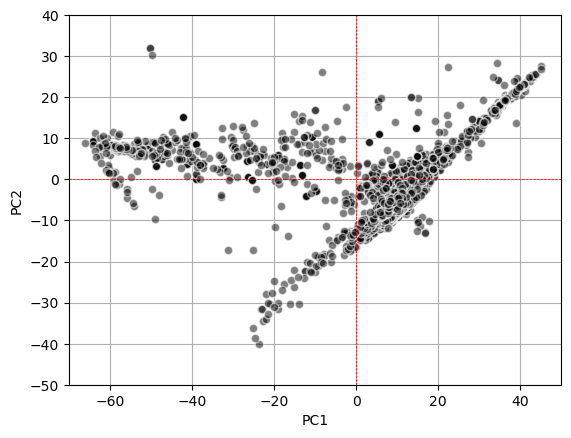

In [17]:
fig, ax = plt.subplots()
ax.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, color='k', edgecolors='w')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.axhline(y=0, color='r', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='r', linestyle='--', linewidth=0.5)
ax.set_xlim(-70, 50)
ax.set_ylim(-50, 40)
ax.set_aspect('equal')
ax.grid(True)
ax.set_axisbelow(True)
plt.show()

In [18]:
# What makes up each PC?

# Loadings (principal component vectors) are the rows of Vt
loadings = pd.DataFrame(Vt.T, index=geochem_cols, columns=[f'PC{i+1}' for i in range(len(geochem_cols))])
print("\nLoadings for PC1 and PC2:")
print(loadings[['PC1', 'PC2']])


Loadings for PC1 and PC2:
            PC1       PC2
SIO2  -0.806909 -0.527342
TIO2  -0.005148  0.015598
AL2O3 -0.119890  0.342946
FEOT  -0.033515  0.342729
MNO    0.005234  0.100487
MGO   -0.019234  0.079938
CAO    0.576097 -0.631013
NA2O  -0.021021  0.093480
K2O   -0.016162  0.145140
P2O5  -0.001995  0.049568
LOI   -0.019521  0.199164


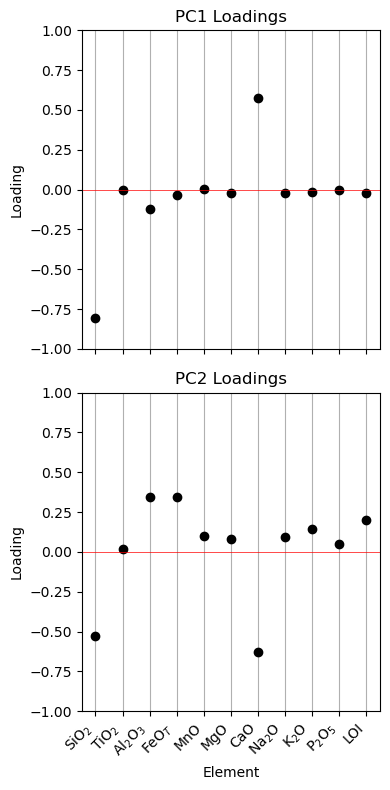

In [19]:
# Why don't we visualize these loadings?
fig, axes = plt.subplots(2, 1, figsize=(4, 8), sharex=True)
x = np.arange(len(geochem_cols))
latex_cols = [latex_labels[col] for col in geochem_cols]

# PC1 loadings
ax1 = axes[0]
ax1.scatter(x, loadings['PC1'], color='black')
ax1.set_ylabel('Loading')
ax1.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
ax1.set_ylim(-1, 1)
ax1.grid(True, axis='x')
ax1.set_axisbelow(True)
ax1.set_title('PC1 Loadings')

# PC2 loadings
ax2 = axes[1]
ax2.scatter(x, loadings['PC2'], color='black')
ax2.set_ylabel('Loading')
ax2.set_xlabel('Element')
ax2.set_xticks(x)
ax2.set_xticklabels(latex_cols, rotation=45, ha='right')
ax2.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
ax2.set_ylim(-1, 1)
ax2.grid(True, axis='x')
ax2.set_axisbelow(True)
ax2.set_title('PC2 Loadings')

plt.tight_layout()
plt.show()